# WGMS reference glaciers - standard projections plots 
### based on _10 minutes to..._ a glacier change projection with GCM data

This notebook creates animations of the modeled evolution of certain glaciers from the year 2000 to the year 2001. The model is forced with the climate predictions of one member of the ISIMIP3b climate model for 3 different climate scenarios(ssp126, ssp370, ssp585).  
To visualize the animations the [oggm-3dviz library](https://github.com/OGGM/oggm-3dviz) is used.

In [1]:
# Libs
import xarray as xr
import matplotlib.pyplot as plt
import os
from os.path import join

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks, DEFAULT_BASE_URL
from oggm.shop import gcm_climate

## Selecting glaciers and setting their plotting/animation attributes here

currently selected a few reference glaciers from [this list](https://wgms.ch/products_ref_glaciers/) for different regions.  
Furthermore certain glaciers of own interest were added to the list(e.g. Upsala, Khumbu)

In [2]:
# glaciers chosen for visualization
glac_dict = {
    # Aletsch
    "Aletsch glacier": {
        "rgi_id": "RGI60-11.01450",
        "camera_params": {
            'azimuth': -135, # rotate around the z-axis
            'elevation': 9,  # elevation angle above ground
            'zoom': 1.45
        },
        "fl_thickness_threshold": 2,
        "rolling_mean_smoothing": 8,
        "crop": {
            "x_crop": 0.37,
            "y_crop": 0.45
        }
    }
}

glac_names = list(glac_dict.keys())
rgi_ids = [glacier["rgi_id"] for glacier in glac_dict.values()]



In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
cfg.PATHS['working_dir'] = '/Users/afisc/atmo_master/rgi_job/oggm-3dviz/reference_glaciers_wd'



# Go - get the pre-processed glacier directories
# You have to explicitly indicate the url from where you want to start from
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=4, prepro_base_url=DEFAULT_BASE_URL)

2024-08-22 13:04:32: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-08-22 13:04:32: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-08-22 13:04:32: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-08-22 13:04:33: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-08-22 13:04:33: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers


rgi_dates:

In [4]:
[(gdir.name, gdir.rgi_date) for gdir in gdirs]

[('', 2003)]

The glacier volume and area changes before that date are highly uncertain and serve the purpose of spinup only! In the ["10 minutes to... a dynamical spinup"](dynamical_spinup.ipynb) tutorial, we talk about why. For now, these files are perfect for our purpose, since we plan to start our simulation in 2020.

## Download and process GCM data from ISIMIP3b (bias-corrected CMIP6)

A typical use case for OGGM will be to use climate model output (here bias-corrected CMIP6 GCMs from [ISIMIP3b](https://www.isimip.org/gettingstarted/isimip3b-bias-adjustment/)). We use the files [we mirrored in Bremen](https://cluster.klima.uni-bremen.de/~oggm/cmip6/isimip3b/flat/monthly/) here, but you can use whichever you want. From ISIMIP3b, we have 5 GCMs and 3 SSPs on the cluster. You can find more information on the [ISIMIP website](https://www.isimip.org/gettingstarted/isimip3b-bias-adjustment). Let's download the data:

In [5]:
# you can choose one of these 5 different GCMs:
# 'gfdl-esm4_r1i1p1f1', 'mpi-esm1-2-hr_r1i1p1f1', 'mri-esm2-0_r1i1p1f1' ("low sensitivity" models, within typical ranges from AR6)
# 'ipsl-cm6a-lr_r1i1p1f1', 'ukesm1-0-ll_r1i1p1f2' ("hotter" models, especially ukesm1-0-ll)
member = 'mri-esm2-0_r1i1p1f1' 

for ssp in ['ssp126', 'ssp370','ssp585']:
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                 ssp = ssp,
                                 # gcm member -> you can choose another one
                                 member=member,
                                 # recognize the climate file for later
                                 output_filesuffix=f'_ISIMIP3b_{member}_{ssp}',
                                 );

2024-08-22 13:04:33: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-08-22 13:04:34: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-08-22 13:04:35: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers


The advantage of using ISIMIP3b data is that they have been bias-corrected by the ISIMIP consortium. Since we are using the [W5E5](https://docs.oggm.org/en/latest/climate-data.html#w5e5) dataset as the baseline climate in OGGM v1.6, there is no need for us to bias correct any further. If you want to bias-correct the projections yourself or want to have a larger variety of GCMs, you can also use the original CMIP5 or CMIP6 GCMs.

If you want to know which historical data you are using, you can ask OGGM:

In [6]:
gdirs[0].get_climate_info()

{'baseline_climate_source': 'GSWP3_W5E5',
 'baseline_yr_0': 1901,
 'baseline_yr_1': 2019,
 'baseline_climate_ref_hgt': 1764.0,
 'baseline_climate_ref_pix_lon': 8.25,
 'baseline_climate_ref_pix_lat': 46.75}

## Projection runs 

We now run OGGM under various scenarios **starting from the end year of the historical spin-up run**:

In [7]:
cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS['store_fl_diagnostics'] = True

2024-08-22 13:04:35: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2024-08-22 13:04:35: oggm.cfg: PARAMS['store_fl_diagnostics'] changed from `False` to `True`.


In [8]:
for ssp in ['ssp126', 'ssp370', 'ssp585']:
    rid = f'_ISIMIP3b_{member}_{ssp}'
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use the chosen scenario
                                 init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2024-08-22 13:04:35: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-08-22 13:04:35: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-08-22 13:04:35: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers


In [9]:
from matplotlib.colors import ListedColormap
# simple cmap that is all white
cmap = ListedColormap(['white', 'white', 'white', 'white'])

add_mesh_ice_thick_args_new = {
    'cmap' : cmap,  # use a different matplotlib cmap
    'show_scalar_bar': False
    
}

In the following cell for each glacier and each of the 3 ssp scenarios the model data is distributed from 1D(flowline) to 2D(gridded) data and plotted with the [oggm-3dviz library](https://github.com/OGGM/oggm-3dviz).

Aletsch glacier (294, 247)


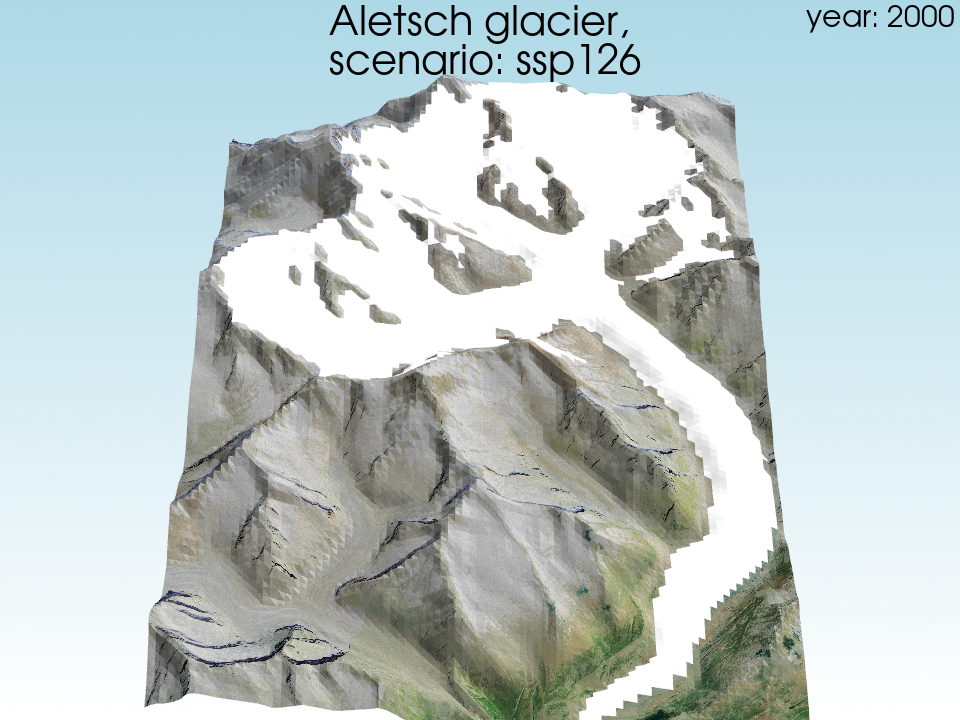

Aletsch glacier (294, 247)


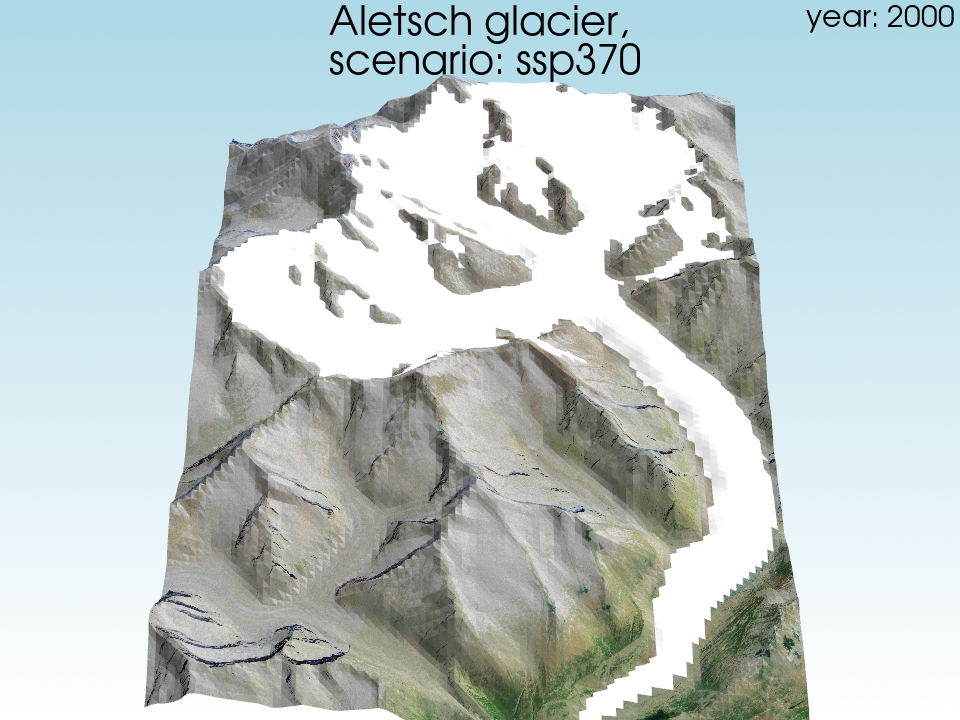

Aletsch glacier (294, 247)


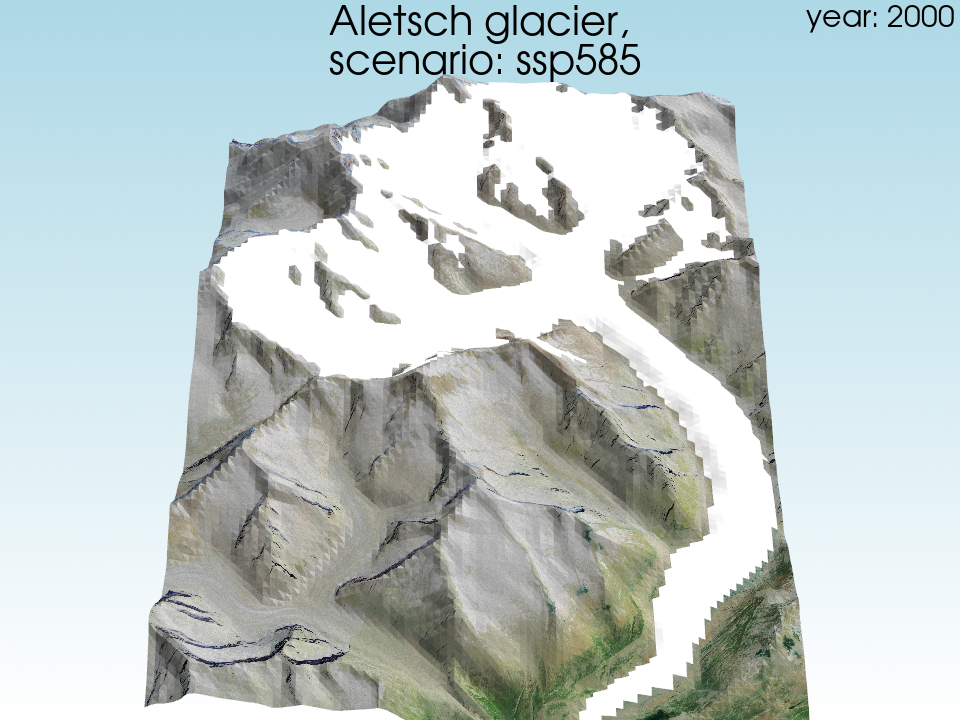

In [10]:
from oggm.sandbox import distribute_2d
from oggm_3dviz.tools import Glacier3DViz
from oggm_3dviz.tools.map_annotations import TextAnnotation

# animations path
animations_path = join(cfg.PATHS['working_dir'], 'animations')
if not os.path.exists(animations_path):
    os.makedirs(animations_path)
dist_ds_outs = []
for i, (glac_name, gdir) in enumerate(zip(glac_names, gdirs)):
    # This is to add a new topography to the file (smoothed differently)
    distribute_2d.add_smoothed_glacier_topo(gdir)
    # This is to get the bed map at the start of the simulation
    tasks.distribute_thickness_per_altitude(gdir)
    # This is to prepare the glacier directory for the interpolation (needs to be done only once)
    distribute_2d.assign_points_to_band(gdir)
    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        dist_ds, dist_ds_out = distribute_2d.distribute_thickness_from_simulation(gdir, 
                                                              input_filesuffix=rid, 
                                                              concat_input_filesuffix='_spinup_historical',
                                                              fl_thickness_threshold=glac_dict[glac_name]['fl_thickness_threshold'],
                                                                rolling_mean_smoothing=glac_dict[glac_name]['rolling_mean_smoothing'],
                                                                debug_area_timeseries=True,
                                                                add_monthly=True
                                                          )
        # saving area debugging data frames
        dist_ds_out['glac_name'] = glac_name
        dist_ds_out['scenario'] = ssp
        dist_ds_outs.append(dist_ds_out)
        
        with xr.open_dataset(gdir.get_filepath('gridded_simulation', filesuffix=f'_ISIMIP3b_{member}_{ssp}')) as ds:
            ds_glacier = ds.sel(time=slice(2000,2101))

            heading = TextAnnotation(
                text=f'{glac_name},\n scenario: {ssp}',
                position='upper_edge',
                font_size=16.5
                )

            if 'crop' in glac_dict[glac_name]:
                x_crop = glac_dict[glac_name]['crop']['x_crop']
                y_crop = glac_dict[glac_name]['crop']['y_crop']
            else:
                x_crop, y_crop = None, None
            print(glac_name, ds_glacier['topo'].shape)
            viz = Glacier3DViz(
                ds_glacier,  # dataset for visualization
                x='x',  # x-coordinate name, default is 'x'
                y='y',  # y-coordinate name, default is 'y'
                time='time',  # time coordinate name, default is 'time'
                topo_bedrock='topo',
                # topo_bedrock='bedrock',  # bedrock data variable, default is 'bedrock'
                use_texture=True, # use satellite texture for the topography
                ice_thickness='simulated_thickness',  # evolving ice thickness variable, default is 'simulated_thickness'
                x_crop=x_crop,
                y_crop=y_crop,
                time_var_display='calendar_year',# time format displayed, opting for total years here
                camera_args=glac_dict[glac_name]['camera_params'],
                additional_annotations=[heading],
                add_mesh_ice_thick_args=add_mesh_ice_thick_args_new
                )
            viz.export_animation(filename=join(animations_path, f'{glac_name}_{ssp}.mp4'),  # filename for the animation, should end with .mp4
                     framerate=80,  # framerate of the animation, affects duration and speed
                     quality=10,  # The range is 0 - 10. Higher quality leads to a larger file.
                    )
                
        

the following cell creates comparison plots for each glacier which has been modeled/animated. This shows the actually modeled area compared to the area which is used when plotting. This area adaption is done to smooth the animation and get rid of flickering.  
These plots are useful to check how much the actual model output is altered for animation purposes.

In [11]:
# creating area plots
for dist in dist_ds_outs:
    glacier_name = dist['glac_name'].iloc[0]
    scenario = dist['scenario'].iloc[0]
    filename=join(animations_path, f'area_graphs_{glacier_name}_{scenario}.png')

    # Plot 'initial_area' and 'smoothed_area'
    plt.figure(figsize=(10, 6))
    plt.plot(dist['initial_area'], label='Initial Area')
    plt.plot(dist['smoothed_area'], label='Smoothed Area')
    plt.xlabel('Year')
    plt.ylabel('Area')
    plt.title(f'Glacier: {glacier_name}, Scenario: {scenario}')
    plt.legend()
    plt.savefig(filename)
    plt.close()